In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import logm, expm

## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)

In [2]:
## Read coordinates and indices

grid_coordinates = []
with open('../Grids/AB_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../Grids/AB_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../Grids/AB_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)

bott_indices = []
with open('Bott_indices.txt', 'r') as reader:
    line = reader.readline()
    
    while line != '':
        ele = line.replace('(', '').replace(')', '')
        elements = ele.split(',')
        package = (float(elements[0]), int(elements[1]))
        line = reader.readline()
        bott_indices.append(package)

# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

In [3]:
## We now want to scale down the plot so it will fit inside a unit square in the 1st quadrant

# Compare x and y components seperatly to for the maximal distances along each axis
xs = [x for x,y in grid_coordinates]
ys = [y for x,y in grid_coordinates]

xs_length = abs(max(xs)) + abs(min(xs))
ys_length = abs(max(ys)) + abs(min(ys))

# We can now scale all xs and ys to fit inside a unit square
xs_scaled = [i/xs_length for i in xs]
ys_scaled = [i/ys_length for i in ys]
grid_scaled = [(x,y) for x, y in zip(xs_scaled, ys_scaled)]

# Same thing for all jump coodinates
jump_scaled = []
for i in jump_coordinates:
    xs_temp = [j[0]/xs_length for j in i]
    ys_temp = [j[1]/ys_length for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_scaled.append(jump_temp)


# The new vertices are stored in grid_scaled
# The new jumps are stored in jump_scaled


## Now we want to move the grid so it lies in the first quadrant 

# We check how much it should be moved along postive x axis and y axis
x_move = min(xs_scaled)
y_move = min(ys_scaled)

# Add the absolute to every coordinate
xs_final = [x + abs(x_move) for x in xs_scaled]
ys_final = [y + abs(y_move) for y in ys_scaled]
grid_final = [(x,y) for x, y in zip(xs_final, ys_final)]

jump_final = []
for i in jump_scaled:
    xs_temp = [j[0] + abs(x_move) for j in i]
    ys_temp = [j[1] + abs(y_move) for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_final.append(jump_temp)


# The new vertices are stored in grid_final
# The new jumps are stored in jump_final

In [4]:
def rotation(phi):
    operator = np.array([[np.cos(phi), -np.sin(phi)],[np.sin(phi), np.cos(phi)]])
    return operator

def translation(vector, coordinate):
    operator = vector + np.array([coordinate[0], coordinate[1]])
    return operator


# This takes a vector from the basis of lattice sites and rotates it n-fold and assigns to a new vector in the same
def rot_op(site, n):
    # Site is a vector describing the coordinate of a supposed occupied site, which we want rotate (1/n)-fold
    # Rads tells the operator how much we should rotate
    rads = (2*np.pi)/(n)
    
    # Now translate the site so that it is placed relative to O and can be rotated
    # Because we have fitted the grid inside a unit square in the 1st quadrant, we know the outer vertices lie on the interval [0,1] with either coordinates
    # Thus we may guess that the point of rotational symmetry is located in (0.5,0.5) which has a distance of 
    dist0 = np.sqrt((0.5)**2 + (0.5)**2)
    # And we can use this to determine the translation relative to O
    # grain adds precision, if very fine only one point should exist
    grain1 = -9
    check_list = [(ele,count) for count, ele in enumerate(np.array(grid_final)) if dist0 - 10**(grain1) <= np.linalg.norm(ele) <= dist0 + 10**(grain1)]
    point_of_interest = check_list[0][0]
    # The following checks if only one element has been found with the guess of point for translation
    if len(check_list) == 0:
        return print('Error: check_list is empty')
    
    elif len(check_list) > 1:
        return print('Error: check_list contains more than one point')
    
    elif len(check_list) == 1:
        # Only one point is found and we continue with translation
        # Since we are in 1st quadrant we may translate as 
        trans_site = translation(np.array(site), (-1)*point_of_interest)
        
        # Rotate site
        trans_rot_site = np.matmul(rotation(rads), trans_site)
        
        # Translate back again
        rot_site = translation(trans_rot_site, point_of_interest)
        
        # We aim to assign the rotated site to an already exisiting coordiante pair, so we will compare with grid_final
        # Check the distance of rot_site
        dist_rot = np.linalg.norm(rot_site)
        
        # Find sites close enough
        grain2 = -6
        close_by_eles = [(ele, count) for count, ele in enumerate(np.array(grid_final)) if dist_rot - 10**(grain2) <= np.linalg.norm(ele) <= dist_rot + 10**(grain2)]
        # Check every coordinate 
        filtered_eles = [w for w in close_by_eles if (rot_site[0] - 10**(grain2) <= w[0][0] <= rot_site[0] + 10**(grain2)) and (rot_site[1] - 10**(grain2) <= w[0][1] <= rot_site[1] + 10**(grain2))]
        # This more than likely only returns one element
        # This element comes with an index which we use to assign the rotated site to the preexisting coordinates
        new_site = grid_final[filtered_eles[0][1]]
        new_x = new_site[0]
        new_y = new_site[1]
        ns_index = filtered_eles[0][1]
        return (new_x, new_y), ns_index
    

# We now use the above function to construct an explicit rotation operator by applying and extracting the index for every basis element
dim = len(grid_final)
R = np.zeros((dim,dim),dtype= np.complex128)
indices = []
for w in range(dim):
    coor, rot_index = rot_op(grid_final[w], 8)
    indices.append(rot_index)

for i, j in zip(range(dim), indices):
    # Note the order is to make sure in the picture of a matrix being made of column vectors, that we get the right non-zero entries
    # If we flip the order we get the transpose. Reason being that np intreprets entries along every row constituting the matrix in stead
    R[j][i] = 1

In [5]:
## DEFINITION OF USEFUL FUNCTIONS

def Hamil_solve(z, w, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [(k[1] - i[1]) * (i[0] + k[0]) for k in j]
        jump_products.append(products)
    phase_factors = []
    for i, j in zip(z, jump_products):
        phases = [(phi/(2 * l**2)) * k for k in j]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = J * np.exp(1j * t)

    # Now we find the eigenvalues and eigenvectors
    # Note that eigh returns normalized eigenvectors!
    # Note the eigenvectors are arranged in a matrix so eig_vecs[:,i] chooses the i'th column which is the i'th eigenvector
    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    return eig_vals, eig_vecs


In [6]:
# We want to know when phi/phi0 = 1, this happens when phi = 2pi
# phi in this case is phi = B*l*2 so B must be equal to
B_full = (2*np.pi)/(0.03825242185233838**2)

# Take field strength of B= 2pi so that phi/phi0= 0.5
evals, evecs = Hamil_solve(grid_final, jump_final, (0.25)*B_full)

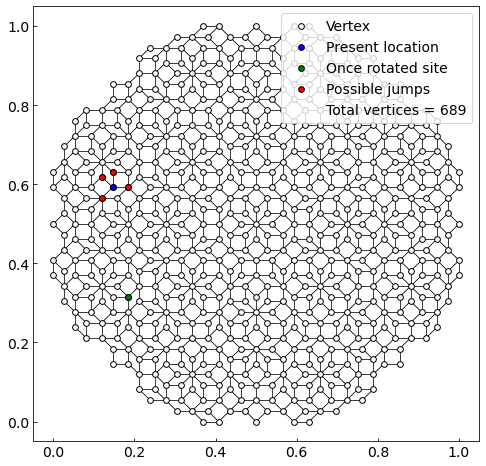

In [7]:
# Define figure
fig, ax = plt.subplots(figsize=(8,8))

# Plot all possible paths between vertices
for i,j in zip(grid_final, jump_final):
    xs = [w[0] for w in j]
    ys = [w[1] for w in j]
    for l,k in zip(xs,ys):
        ax.plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 0.5)


# Choose index to highlight a specific vertex and its connecting points
# We will use to attempt to make rotation operator, keep ind= 42
ind_choice = 42

xs_jumps = [w[0] for w in jump_final[ind_choice]]
ys_jumps = [w[1] for w in jump_final[ind_choice]]

marker_size = 33

coors, index = rot_op(grid_final[42],8)
x_rot = coors[0]
y_rot = coors[1]

ax.scatter(x= xs_final, y= ys_final, s= marker_size, facecolor= 'w', edgecolor= 'k', label= "Vertex", linewidth= 1)
ax.scatter(x= xs_final[ind_choice], y= ys_final[ind_choice], s= marker_size, facecolor= 'b', edgecolor= 'k', label= "Present location", linewidth= 1)
ax.scatter(x= x_rot, y= y_rot, s= marker_size, facecolor= 'g', edgecolor= 'k', label= "Once rotated site", linewidth= 1)
ax.scatter(x= xs_jumps, y= ys_jumps, s= marker_size, facecolor= 'r', edgecolor= 'k', label= "Possible jumps", linewidth= 1)
ax.plot([],[], linestyle= '', label= "Total vertices = {}".format(len(grid_coordinates)))

ax.legend(loc= 1)

plt.show()

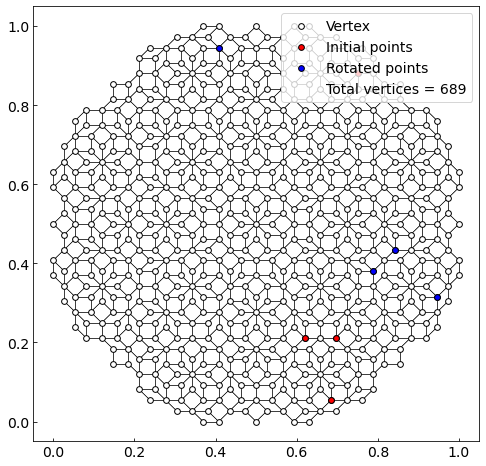

In [8]:
# Proof of concept for the R operator
# Take a matrix of 4 random entries
rand_indices = np.random.randint(0,dim, 4)
# Generate a vector of chosen sites
vec = np.zeros(dim, dtype= int)
for i in rand_indices:
    vec[i] = 1

# Apply R and extract indices
rot_vec = np.matmul(R,vec)
rot_ind = [index for index, ele in enumerate(rot_vec) if ele == 1]

# Get coordinates from grid_final
coors_rot = [grid_final[i] for i in rot_ind]

# Get original coordinates
coors_ini = [grid_final[i] for i in rand_indices]

# Define figure
fig, ax = plt.subplots(figsize=(8,8))

# Plot all possible paths between vertices
for i,j in zip(grid_final, jump_final):
    xs = [w[0] for w in j]
    ys = [w[1] for w in j]
    for l,k in zip(xs,ys):
        ax.plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 0.5)


# Choose index to highlight a specific vertex and its connecting points
# We will use to attempt to make rotation operator, keep ind= 42
ind_choice = 42

marker_size = 33

ax.scatter(x= xs_final, y= ys_final, s= marker_size, facecolor= 'w', edgecolor= 'k', label= "Vertex", linewidth= 1)
for w, text, col in zip([coors_ini, coors_rot], ["Initial points", "Rotated points"], ['r', 'b']):
    xs = [x for x,y in w]
    ys = [y for x,y in w]
    ax.scatter(xs, ys, s= marker_size, facecolor= col, edgecolor= 'k', label= text, linewidth= 1)
ax.plot([],[], linestyle= '', label= "Total vertices = {}".format(len(grid_coordinates)))

ax.legend(loc= 1)

plt.show()

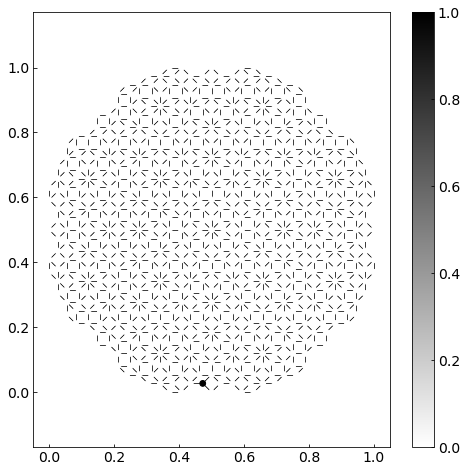

In [9]:
# This function describes a particle localised in the site basis as a linear comb. of hamilton evecs choosing those with Bott index != 0
# This is know as BLT-states
def site_to_blt_plotting(state):
    # Localise a particle in site basis, and describe it as a linear combination in the basis of eigenvectors of the hamiltonian
    local_particle = np.zeros(dim, dtype= np.complex128)
    local_particle[state] = 1
    
 
    # We take the inner product of localised particle and all eigenstates of the hamilton
    # The coefficients will be used for creating phi as a linear combination of eigenstates
    cns = [np.vdot(x, local_particle) for x in evecs]
    
    # We can write phi in the basis of eigenstates for the hamiltonian
    # This amounts to selecting cns where the bott index is B != 0
    phi = np.zeros(len(evals), dtype= np.complex128)
    for i in bott_indices:
        phi[i[1]] = cns[i[1]]

    # We would like to know what phi is now in the basis of lattice sites. To do this we construct coordinate transformation matrix
    # Start by calculating the inner produts of vdot(ei, sk) for all k this will be the i'th column. s denotes site vectors
    # Site vectors have one entry equal to 1 while the rest are equal to 0. Thus the i,k'th inner product is just selecting the k'th value the i'th vectors complex conjugate
    # This means the coordinate transformation matrix ith column is just the ith eigenvector
    T = np.zeros((len(evals), len(evals)), dtype= np.complex128)
    for i in range(len(evals)):
        T[:, i] = evecs[i]
    # Now we can transform phi_evolve into the basis of lattice sites
    phi_lat = np.matmul(T,phi)
    # phi is normalised 
    phi_norm = phi_lat / (np.sqrt(np.vdot(phi_lat,phi_lat)))

    return phi_norm

def site_to_evec_plotting(state):
    # Localise a particle in site basis, and describe it as a linear combination in the basis of eigenvectors of the hamiltonian
    local_particle = np.zeros(dim, dtype= np.complex128)
    local_particle[state] = 1
    
 
    # We take the inner product of localised particle and all eigenstates of the hamilton
    # The coefficients will be used for creating phi as a linear combination of eigenstates
    cns = [np.vdot(x, local_particle) for x in evecs]
    
    # We can write phi in the basis of eigenstates for the hamiltonian
    phi = np.zeros(len(evals), dtype= np.complex128)
    for i, ele in enumerate(cns):
        phi[i] = ele

    # We would like to know what phi is now in the basis of lattice sites. To do this we construct coordinate transformation matrix
    # Start by calculating the inner produts of vdot(ei, sk) for all k this will be the i'th column. s denotes site vectors
    # Site vectors have one entry equal to 1 while the rest are equal to 0. Thus the i,k'th inner product is just selecting the k'th value the i'th vectors complex conjugate
    # This means the coordinate transformation matrix ith column is just the ith eigenvector
    T = np.zeros((len(evals), len(evals)), dtype= np.complex128)
    for i in range(len(evals)):
        T[:, i] = evecs[i]
    # Now we can transform phi_evolve into the basis of lattice sites
    phi_lat = np.matmul(T,phi)
    # phi is normalised 
    phi_norm = phi_lat / (np.sqrt(np.vdot(phi_lat,phi_lat)))

    return phi_norm

def site_to_evec(state):
    # Localise a particle in site basis, and describe it as a linear combination in the basis of eigenvectors of the hamiltonian
    local_particle = np.zeros(dim, dtype= np.complex128)
    local_particle[state] = 1
    
 
    # We take the inner product of localised particle and all eigenstates of the hamilton
    # The coefficients will be used for creating phi as a linear combination of eigenstates
    cns = [np.vdot(x, local_particle) for x in evecs]
    
    # We can write phi in the basis of eigenstates for the hamiltonian
    phi = np.zeros(len(evals), dtype= np.complex128)
    for i, ele in enumerate(cns):
        phi[i] = ele

    # Now we can normalize and return 
    phi_norm = phi / (np.sqrt(np.vdot(phi,phi)))

    return phi_norm

site_of_interest = 373
psi = site_to_evec_plotting(site_of_interest)

densities = [(x.conj() * x).real for x in psi]


# Define figure
fig, ax = plt.subplots(figsize=(8,8))

# Plot all possible paths between vertices
for i,j in zip(grid_final, jump_final):
    xs = [w[0] for w in j]
    ys = [w[1] for w in j]
    for l,k in zip(xs,ys):
        ax.plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 0.5)

marker_size = 33

xs = [w[0] for w in grid_final]
ys = [w[1] for w in grid_final]

# Set colour gradient
plt.set_cmap('binary')

# Plot, noting c sets the density
cax = ax.scatter(x= xs, y= ys, s= marker_size, c= densities, zorder= 3, facecolor= 'r')
# Attach colorbar
fig.colorbar(cax)

# Finalize
plt.axis('equal')

plt.show()

In [10]:
# Now the rotation operator and Hamiltonian commute
# Therefore there exists a simultaneous eigenbasis of energy-eigenstates and eigenstates of the rotation operator
# We know test what kind of phase we get, when we apply the rotation operator

evecs_rotated = [np.matmul(R,e) for e in evecs]

In [11]:
def arg(z):
    x = z.real
    y = z.imag
    if y >= 0:
        arg = np.arctan2(y,x)
        return arg
    elif y < 0:
        arg = 2*np.pi + np.arctan2(y,x)
        return arg

phases_before = [arg(z) for z in evecs[0]]
phases_after = [arg(z) for z in evecs_rotated[0]]

In [31]:
# Check for any degeneracies in energy eigen functions

def check_degeneracy(eval):
    deg_ener = []
    for count, ele in enumerate(eval):
        evals_list = list(eval)
        eles = [z for z in eval if ele == z and evals_list.index(z) != count]
        if len(eles) > 0:
            deg_ener.append(eles)
        else:
            pass
    if len(deg_ener) == 0:
        return print('No degeneracies were found')
    else:
        return print('Degeneracies were found')

In [34]:
# Write the rotation operatpr in the basis of energy eigen functions
# Firstly we calculate the matrix elements, we do this per row
dim = len(evecs)
cns = np.array([[np.vdot(i, j) for j in evecs_rotated] for i in evecs_rotated])

R_eef = np.zeros((dim,dim), dtype= np.complex128)

for i in range(dim):
    for j in range(dim):
        R_eef[i][j] = cns[i][j]

In [37]:
R_eef[1]

array([ 2.01227923e-16+5.81132364e-17j,  1.00000000e+00+0.00000000e+00j,
       -5.57713598e-16+2.77555756e-17j, -2.17707796e-16-3.12250226e-17j,
       -5.55111512e-17+3.46944695e-17j,  1.30104261e-16+1.73472348e-17j,
       -1.51923829e-16+4.85722573e-17j, -1.38344197e-16-3.85975973e-17j,
       -6.76542156e-17-2.05998413e-17j,  3.46944695e-17+0.00000000e+00j,
       -2.60208521e-18+2.01661604e-17j, -6.93889390e-17+2.08166817e-17j,
        2.02962647e-16+9.75781955e-19j, -2.74519990e-16+7.80625564e-18j,
        2.35705552e-16+2.08166817e-17j, -1.52655666e-16-9.71445147e-17j,
        3.12250226e-17+2.08166817e-17j,  3.12250226e-16-9.54097912e-18j,
       -3.12250226e-17+2.62376926e-17j,  4.90926744e-16-3.55618313e-17j,
        5.88071258e-16-2.16840434e-17j, -1.83447008e-16-1.38777878e-17j,
        5.72458747e-17-1.90819582e-17j,  1.52655666e-16-5.20417043e-18j,
        1.60678762e-16+1.04083409e-17j,  1.73472348e-17+2.77555756e-17j,
       -7.45931095e-17-3.12250226e-17j,  1.40512602